Adjoint inverse reconstruction
==============================

Introduction
------------
In this tutorial, we will demonstrate how to perform an inversion to recover the initial temperature field of an
idealised mantle convection simulation using G-ADOPT. This tutorial is published as the first synthetic experiment in
*Ghelichkhan et al. (2024)*. The full inversion showcased in the publication involves a total number of 80 timesteps.
For the tutorial here we start with only 5 timesteps to go through the basics.

The tutorial involves a *twin experiment*, where we assess the performance of the inversion scheme by inverting the
initial state of a synthetic reference simulation, known as the "*Reference Twin*". To create this reference twin, we
run a forward mantle convection simulation and record all relevant fields (velocity and temperature) at each time step.

We have pre-run this simulation by running [the forward case](../adjoint_forward), and stored model output as a
checkpoint file on our servers.  These fields serve as benchmarks for evaluating our inverse problem's performance. To
download the reference benchmark checkpoint file if it doesn't already exist, execute the following command:

In [1]:
![ ! -f adjoint-demo-checkpoint-state.h5 ] && wget https://data.gadopt.org/demos/adjoint-demo-checkpoint-state.h5

In this file, fields from the reference simulation are stored under the names "Temperature" and "Velocity".
After importing g-adopt and the associated inverse module (gadopt.inverse - discussed further below), we can
retrieve timestepping information from the pre-computed forward run as follows

In [2]:
from gadopt import *
from gadopt.inverse import *

# Open the checkpoint file and subsequently load the mesh:
checkpoint_filename = "adjoint-demo-checkpoint-state.h5"
checkpoint_file = CheckpointFile(checkpoint_filename, mode="r")
mesh = checkpoint_file.load_mesh("firedrake_default_extruded")
mesh.cartesian = True

# Specify boundary markers, noting that for extruded meshes the upper and lower boundaries are tagged as
# "top" and "bottom" respectively.
bottom_id, top_id, left_id, right_id = "bottom", "top", 1, 2

# Retrieve the timestepping information for the Velocity and Temperature functions from checkpoint file:
temperature_timestepping_info = checkpoint_file.get_timestepping_history(mesh, "Temperature")
velocity_timestepping_info = checkpoint_file.get_timestepping_history(mesh, "Velocity")

We can check the information for each:

In [3]:
print("Timestepping info for Temperature", temperature_timestepping_info)
print("Timestepping info for Velocity", velocity_timestepping_info)

Timestepping info for Temperature {'index': array([ 0., 79.])}
Timestepping info for Velocity {'index': array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
       39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51.,
       52., 53., 54., 55., 56., 57., 58., 59., 60., 61., 62., 63., 64.,
       65., 66., 67., 68., 69., 70., 71., 72., 73., 74., 75., 76., 77.,
       78., 79.]), 'delta_t': array([4.e-06, 4.e-06, 4.e-06, 4.e-06, 4.e-06, 4.e-06, 4.e-06, 4.e-06,
       4.e-06, 4.e-06, 4.e-06, 4.e-06, 4.e-06, 4.e-06, 4.e-06, 4.e-06,
       4.e-06, 4.e-06, 4.e-06, 4.e-06, 4.e-06, 4.e-06, 4.e-06, 4.e-06,
       4.e-06, 4.e-06, 4.e-06, 4.e-06, 4.e-06, 4.e-06, 4.e-06, 4.e-06,
       4.e-06, 4.e-06, 4.e-06, 4.e-06, 4.e-06, 4.e-06, 4.e-06, 4.e-06,
       4.e-06, 4.e-06, 4.e-06, 4.e-06, 4.e-06, 4.e-06, 4.e-06, 4.e-06,
       4

The timestepping information reveals that there are 80 time-steps (from 0 to 79) in the reference simulation,
with the temperature field stored only at the initial (index=0) and final (index=79) timesteps, while the
velocity field is stored at all timesteps. We can visualise the benchmark fields using Firedrake's built-in VTK
functionality. For example, initial and final temperature fields can be loaded:

In [4]:
# Load the final state, analagous to the present-day "observed" state:
Tobs = checkpoint_file.load_function(mesh, "Temperature", idx=int(temperature_timestepping_info["index"][-1]))
Tobs.rename("Observed Temperature")
# Load the reference initial state - i.e. the state that we wish to recover:
Tic_ref = checkpoint_file.load_function(mesh, "Temperature", idx=int(temperature_timestepping_info["index"][0]))
Tic_ref.rename("Reference Initial Temperature")
checkpoint_file.close()

These fields can be visualised using standard VTK software, such as Paraview or pyvista.

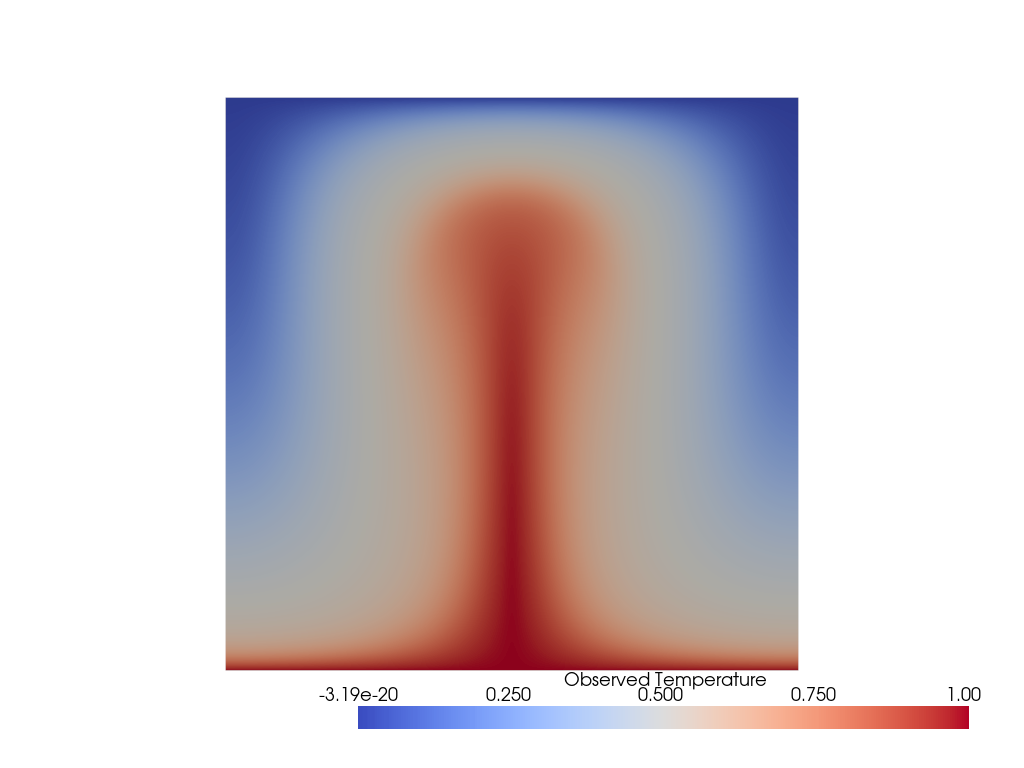

In [5]:
import pyvista as pv
VTKFile("./visualisation_vtk.pvd").write(Tobs, Tic_ref)
dataset = pv.read('./visualisation_vtk.pvd')
# Create a plotter object
plotter = pv.Plotter()
# Add the dataset to the plotter
plotter.add_mesh(dataset, scalars='Observed Temperature', cmap='coolwarm')
# Adjust the camera position
plotter.camera_position = [(0.5, 0.5, 2.5), (0.5, 0.5, 0), (0, 1, 0)]
# Show the plot
plotter.show(jupyter_backend="static")

The inverse code
----------------

The novelty of using the overloading approach provided by pyadjoint is that it requires
minimal changes to our script to enable the inverse capabalities of G-ADOPT.
To turn on the adjoint, one simply imports the inverse module (already done above) to
enable all taping functionality from pyadjoint.

Doing so will turn Firedrake's objects to overloaded types, in a way
that any UFL operation will be annotated and added to the tape, unless
otherwise specified.

We first ensure that the tape is cleared of any previous operations, using the following code:

In [6]:
tape = get_working_tape()
tape.clear_tape()

In [7]:
# To verify the tape is empty, we can print all blocks:
print(tape.get_blocks())

[]


From here on, all user operations are specified with minimal differences relative to
to our forward code. Under the hood, however, the tape will be populated
by *blocks* that record their dependencies. Knowing the mesh was loaded above, we continue
in a manner that is consistent with our most basic forward modelling tutorials.

In [8]:
# Set up function spaces:
V = VectorFunctionSpace(mesh, "CG", 2)  # Velocity function space (vector)
W = FunctionSpace(mesh, "CG", 1)  # Pressure function space (scalar)
Q = FunctionSpace(mesh, "CG", 2)  # Temperature function space (scalar)
Z = MixedFunctionSpace([V, W])  # Mixed function space

# Specify test functions and functions to hold solutions:
z = Function(Z)  # A field over the mixed function space Z
u, p = split(z)  # Returns symbolic UFL expression for u and p
z.subfunctions[0].rename("Velocity")
z.subfunctions[1].rename("Pressure")
T = Function(Q, name="Temperature")

# Specify important constants for the problem, alongside the approximation:
Ra = Constant(1e6)  # Rayleigh number
approximation = BoussinesqApproximation(Ra)

# Define time-stepping parameters:
delta_t = Constant(4e-6)  # Constant time step
timesteps = int(temperature_timestepping_info["index"][-1]) + 1  # number of timesteps from forward

# Nullspaces for the problem are next defined:
Z_nullspace = create_stokes_nullspace(Z, closed=True, rotational=False)

# Followed by boundary conditions, noting that all boundaries are free slip, whilst the domain is
# heated from below (T = 1) and cooled from above (T = 0).
stokes_bcs = {
    bottom_id: {"uy": 0},
    top_id: {"uy": 0},
    left_id: {"ux": 0},
    right_id: {"ux": 0},
}
temp_bcs = {
    bottom_id: {"T": 1.0},
    top_id: {"T": 0.0},
}

# Setup Energy and Stokes solver
energy_solver = EnergySolver(T, u, approximation, delta_t, ImplicitMidpoint, bcs=temp_bcs)
stokes_solver = StokesSolver(z, T, approximation, bcs=stokes_bcs,
                             nullspace=Z_nullspace, transpose_nullspace=Z_nullspace, constant_jacobian=True)

Define the Control Space
------------------------

In this section, we define the control space, which can be restricted to reduce the risk of encountering an
undetermined problem. Here, we select the Q1 function space for the initial condition $T_{ic}$. We also provide an
initial guess for the control value, which in this synthetic test is the temperature field of the reference
simulation at the final time-step (`timesteps - 1`). In other words, our guess for the initial temperature
is the final model state.

In [9]:
# Define control function space:
Q1 = FunctionSpace(mesh, "CG", 1)

# Create a function for the initial temperature field:
Tic = Function(Q1, name="Initial Temperature")

# Project the temperature field from the reference simulation's final time-step onto the control space as our
# initial guess:
with CheckpointFile(checkpoint_filename, mode="r") as fi:
    Tic.project(fi.load_function(mesh, "Temperature", idx=timesteps - 1))

In [10]:
# We next make pyadjoint aware of our control problem:
control = Control(Tic)

In [11]:
# Take our initial guess and project from Q1 to Q2, simultaneously imposing strong temperature boundary conditions.
T.project(Tic, bcs=energy_solver.strong_bcs)

Coefficient(WithGeometry(FunctionSpace(<firedrake.mesh.ExtrudedMeshTopology object at 0x71617257bf20>, TensorProductElement(FiniteElement('Lagrange', interval, 2), FiniteElement('Lagrange', interval, 2), cell=TensorProductCell(interval, interval)), name=None), Mesh(VectorElement(TensorProductElement(FiniteElement('Lagrange', interval, 1), FiniteElement('Lagrange', interval, 1), cell=TensorProductCell(interval, interval)), dim=2), 1)), 40)

We continue by integrating the solutions at each time-step.
Notice that we cumulatively compute the misfit term with respect to the
surface velocity observable.

In [12]:
u_misfit = 0.0

# Next populate the tape by running the forward simulation. ** NOTE ** for the purpose of this tutorial, we only
# invert for a total of 5 time-steps. This makes it tractable to run this within a tutorial session. To run for
# the simulation's full duration, change the initial time-step to `0` instead of `timesteps - 5`.
initial_timestep = timesteps - 5
for time_idx in range(initial_timestep, timesteps):
    stokes_solver.solve()
    energy_solver.solve()
    # Update the accumulated surface velocity misfit using the observed value.
    with CheckpointFile(checkpoint_filename, mode="r") as fi:
        uobs = fi.load_function(mesh, name="Velocity", idx=time_idx)
    u_misfit += assemble(dot(u - uobs, u - uobs) * ds_t)

Define the Objective Functional
-------------------------------

Now that all calculations are in place, we must define *the objective functional*.
The objective functional is our way of expressing our goal for this optimisation.
It is composed of several terms, each representing a different aspect of the model's
performance and regularisation.

Regularisation involves imposing constraints on solutions to prevent overfitting, ensuring that the model
generalises well to new data. In this context, we use the one-dimensional (1-D) temperature profile derived from
the reference simulation as our regularisation constraint. This profile, referred to below as `Taverage`, helps
stabilise the inversion process by providing a benchmark that guides the solution towards physically plausible states.

The 1-D profile, `Taverage`, is also loaded from the checkpoint file

In [13]:
# Load the 1-D average temperature profile from checkpoint file:
Taverage = Function(Q1, name="Average Temperature")
with CheckpointFile(checkpoint_filename, mode="r") as fi:
    Taverage.project(fi.load_function(mesh, "Average Temperature", idx=0))

We use `Taverage` as a part of the damping and smoothing terms in our regularisation.
Consequently, the complete objective functional is defined mathematically as follows:

Reiterating that:
- $T_{ic}$ is the initial temperature condition.
- $T_{\text{average}}$ is the average temperature profile representing mantle's geotherm.
- $T_{F}$ is the the temperature field at final time-step.
- $T_{\text{obs}}$ is the observed temperature field at the final time-step.
- $u_{\text{obs}}$ is the observed velocity field at *each time-step*.
- $\alpha_u$, $\alpha_d$, $\alpha_s$ are the three different
  weighting terms for the velocity, damping and smoothing terms.

We define the objective functional as
$$ \text{Objective Functional}= \int_{\Omega}(T - T_{\text{obs}}) ^ 2 \, dx \\
                 +\alpha_u\, \frac{D_{T_{obs}}}{N\times D_{u_{obs}}}\sum_{i}\int_{\partial \Omega_{\text{top}}}(u - u_{\text{obs}}) \cdot(u - u_{\text{obs}}) \, ds \\
                 +\alpha_s\, \frac{D_{T_{obs}}}{D_{\text{smoothing}}}\int_{\Omega} \nabla(T_{ic} - T_{\text{average}}) \cdot \nabla(T_{ic} - T_{\text{average}}) \, dx \\
                 +\alpha_d\, \frac{D_{T_{obs}}}{D_{\text{damping}}}\int_{\Omega}(T_{ic} - T_{\text{average}}) ^ 2 \, dx $$

With the three *normlisation terms* of:
+ $D_{\text{damping}} = \int_{\Omega} T_{\text{average}}^2 \, dx$,
+ $D_{\text{smoothing}} = \int_{\Omega} \nabla T_{\text{obs}} \cdot \nabla T_{\text{obs}} \, dx$,
+ $D_{T_{obs}} = \int_{\Omega} T_{\text{obs}} ^ 2 \, dx$, and
+ $D_{\text{damping}} = \int_{\partial \Omega_{\text{top}}} u_{\text{obs}} \cdot u_{\text{obs}} \, ds$

which we specify through the `objective` below:

In [14]:
# Define component terms of overall objective functional and their normalisation terms:
damping = assemble((Tic - Taverage) ** 2 * dx)
norm_damping = assemble(Taverage**2 * dx)
smoothing = assemble(dot(grad(Tic - Taverage), grad(Tic - Taverage)) * dx)
norm_smoothing = assemble(dot(grad(Tobs), grad(Tobs)) * dx)
norm_obs = assemble(Tobs**2 * dx)
norm_u_surface = assemble(dot(uobs, uobs) * ds_t)

# Temperature misfit between final state solution and observation:
t_misfit = assemble((T - Tobs) ** 2 * dx)

# Weighting terms
alpha_u = 1e-1
alpha_d = 1e-2
alpha_s = 1e-1

# Define overall objective functional:
objective = (
    t_misfit +
    alpha_u * (norm_obs * u_misfit / timesteps / norm_u_surface) +
    alpha_d * (norm_obs * damping / norm_damping) +
    alpha_s * (norm_obs * smoothing / norm_smoothing)
)

Define the Reduced Functional
-----------------------------

In optimisation terminology, a reduced functional is a functional that takes a given value for the control and outputs
the value of the objective functional defined for it. It does this without explicitly depending on all intermediary
state variables, hence the name "reduced".

To define the reduced functional, we provide the class with an objective (which is an overloaded UFL object) and the control.

In [15]:
reduced_functional = ReducedFunctional(objective, control)

At this point, we have completed annotating the tape with the necessary information from running the forward simulation.
To prevent further annotations during subsequent operations, we stop the annotation process. This ensures that no additional
solves are unnecessarily recorded, keeping the tape focused only on the essential steps.

In [16]:
pause_annotation()

We can print the contents of the tape at this stage to verify that it is not empty.

In [17]:
print(tape.get_blocks())

[<firedrake.adjoint_utils.blocks.assembly.AssembleBlock object at 0x71611a688290>, <firedrake.adjoint_utils.blocks.solving.ProjectBlock object at 0x71611a688050>, <firedrake.adjoint_utils.blocks.dirichlet_bc.DirichletBCBlock object at 0x71610e8fc4d0>, <firedrake.adjoint_utils.blocks.dirichlet_bc.DirichletBCBlock object at 0x71610e8fc0b0>, <firedrake.adjoint_utils.blocks.solving.ProjectBlock object at 0x7161273a50d0>, <firedrake.adjoint_utils.blocks.function.FunctionAssignBlock object at 0x71610c039310>, <firedrake.adjoint_utils.blocks.dirichlet_bc.DirichletBCBlock object at 0x71610c03bcb0>, <firedrake.adjoint_utils.blocks.dirichlet_bc.DirichletBCBlock object at 0x71610c03be30>, <firedrake.adjoint_utils.blocks.dirichlet_bc.DirichletBCBlock object at 0x71610c03bc50>, <firedrake.adjoint_utils.blocks.dirichlet_bc.DirichletBCBlock object at 0x71610c03be90>, <firedrake.adjoint_utils.blocks.solving.NonlinearVariationalSolveBlock object at 0x71610c03b890>, <firedrake.adjoint_utils.blocks.funct

Verification of Gradients: Taylor Remainder Convergence Test
------------------------------------------------------------

A fundamental tool for verifying gradients is the Taylor remainder convergence test. This test helps ensure that
the gradients computed by our optimisation algorithm are accurate. For the reduced functional, $J(T_{ic})$, and its derivative,
$\frac{\mathrm{d} J}{\mathrm{d} T_{ic}}$, the Taylor remainder convergence test can be expressed as:

$$ \left| J(T_{ic} + h \,\delta T_{ic}) - J(T_{ic}) - h\,\frac{\mathrm{d} J}{\mathrm{d} T_{ic}} \cdot \delta T_{ic} \right| \longrightarrow 0 \text{ at } O(h^2). $$

The expression on the left-hand side is termed the second-order Taylor remainder. This term's convergence rate of $O(h^2)$ is a robust indicator for
verifying the computational implementation of the gradient calculation. Essentially, if you halve the value of $h$, the magnitude
of the second-order Taylor remainder should decrease by a factor of 4.

We employ these so-called *Taylor tests* to confirm the accuracy of the determined gradients. The theoretical convergence rate is
$O(2.0)$, and achieving this rate indicates that the gradient information is accurate down to floating-point precision.

### Performing Taylor Tests

In our implementation, we perform a second-order Taylor remainder test for each term of the objective functional. The test involves
computing the functional and the associated gradient when randomly perturbing the initial temperature field, $T_{ic}$, and subsequently
halving the perturbations at each level.

Here is how you can perform a Taylor test in the code:

In [18]:
# Define the perturbation in the initial temperature field
import numpy as np
Delta_temp = Function(Tic.function_space(), name="Delta_Temperature")
Delta_temp.dat.data[:] = np.random.random(Delta_temp.dat.data.shape)

# Perform the Taylor test to verify the gradients
minconv = taylor_test(reduced_functional, Tic, Delta_temp)

Running Taylor test


Computed residuals: [np.float64(0.002461698491252115), np.float64(0.0006154245910616791), np.float64(0.00015385614379664932), np.float64(3.846403545316679e-05)]
Computed convergence rates: [np.float64(2.0000000744323745), np.float64(2.000000037214799), np.float64(2.00000001860362)]


The `taylor_test` function computes the Taylor remainder and verifies that the convergence rate is close to the theoretical value of $O(2.0)$. This ensures
that our gradients are accurate and reliable for optimisation.

Running the inversion
---------------------
In the final section of this tutorial, we run the optimisation method. First, we define lower and upper bounds for the optimisation problem to guide
the optimisation method towards a more constrained solution.

For this simple problem, we perform a bounded nonlinear optimisation where the temperature is only permitted to lie in the range [0, 1]. This means that the
optimisation problem should not search for solutions beyond these values.

In [19]:
# Define lower and upper bounds for the temperature
T_lb = Function(Tic.function_space(), name="Lower Bound Temperature")
T_ub = Function(Tic.function_space(), name="Upper Bound Temperature")

# Assign the bounds
T_lb.assign(0.0)
T_ub.assign(1.0)

# Define the minimisation problem, with the goal to minimise the reduced functional
# Note: in some scenarios, the goal might be to maximise (rather than minimise) the functional.
minimisation_problem = MinimizationProblem(reduced_functional, bounds=(T_lb, T_ub))

Using the Lin-Moré Optimiser
----------------------------

In this tutorial, we employ the trust region method of Lin and Moré (1999) implemented in ROL (Rapid Optimization Library).
Lin-Moré is a truncated Newton method, which involves the repeated application of an iterative algorithm to approximately
solve Newton’s equations (Dembo and Steihaug, 1983).

Lin-Moré effectively handles provided bound constraints by ensuring that variables remain within their specified bounds.
During each iteration, variables are classified into "active" and "inactive" sets. Variables at their bounds that do not
allow descent are considered active and are fixed during the iteration. The remaining variables, which can change without
violating the bounds, are inactive. These properties make the algorithm robust and efficient for solving bound-constrained
optimisation problems.

For our solution of the optimisation problem we use the pre-defined paramters set in gadopt by using `minimsation_parameters`.
Here, we set the number of iterations to only 10, as opposed to the default 100. We also adjust the step-length for this problem,
by setting it to a lower value than our default.

In [20]:
minimisation_parameters["Status Test"]["Iteration Limit"] = 10
minimisation_parameters["Step"]["Trust Region"]["Initial Radius"] = 1e-2

A notable feature of this optimisation approach in ROL is its checkpointing capability. For every iteration,
all information necessary to restart the optimisation from that iteration is saved in the specified `checkpoint_dir`.

In [21]:
# Define the LinMore Optimiser class with checkpointing capability:
optimiser = LinMoreOptimiser(
    minimisation_problem,
    minimisation_parameters,
    checkpoint_dir="optimisation_checkpoint",
)

For sake of book-keeping the simulation, we have also implemented a user-defined way of
recording information that might be used to check the optimisation performance. This
callback function will be executed at the end of each iteration. Here, we write out
the control field, i.e., the reconstructed intial temperature field, at the end of
each iteration. To access the last value of *an overloaded object* we should access the
`.block_variable.checkpoint` method as below.

For the sake of this demo, we also record the values of the reduced
functional directly in order to produce a plot of the convergence.

In [22]:
solutions_vtk = VTKFile("solutions.pvd")
solution_container = Function(Tic.function_space(), name="Solutions")
functional_values = []


def callback():
    solution_container.assign(Tic.block_variable.checkpoint)
    solutions_vtk.write(solution_container)
    final_temperature_misfit = assemble(
        (T.block_variable.checkpoint - Tobs) ** 2 * dx
    )
    log(f"Terminal Temperature Misfit: {final_temperature_misfit}")


def record_value(value, *args):
    functional_values.append(value)


optimiser.add_callback(callback)
reduced_functional.eval_cb_post = record_value

# If it existed, we could restore the optimisation from last checkpoint:
# optimiser.restore()

# Run the optimisation
optimiser.run()


Lin-More Trust-Region Method (Type B, Bound Constraints)
  iter  value          gnorm          snorm          delta          #fval     #grad     #hess     #proj     tr_flag   iterCG    flagCG    
  0     2.618340e-02   3.282031e-01   ---            1.000000e-02   1         1         0         2         ---       ---       ---       


Terminal Temperature Misfit: 0.002730270216817731


  1     2.618340e-02   3.282031e-01   1.000000e-02   2.500000e-03   2         1         11        10        2         5         3         


Terminal Temperature Misfit: 0.002730270216817731


  2     2.514667e-02   3.276274e-01   2.500000e-03   2.500000e-03   3         2         22        18        0         5         3         


Terminal Temperature Misfit: 0.0026847120783287815


  3     2.364173e-02   3.008501e-01   8.380994e-04   2.500000e-02   4         3         26        23        0         2         0         


Terminal Temperature Misfit: 0.002674307313298515


  4     2.283938e-02   3.212996e-01   9.753432e-04   2.500000e-01   5         4         33        28        0         4         0         


Terminal Temperature Misfit: 0.002643519041403283


  5     2.171406e-02   3.057954e-01   2.360050e-03   2.500000e+00   6         5         40        33        0         4         0         


Terminal Temperature Misfit: 0.0025603285243675747


  6     2.063592e-02   3.068344e-01   3.245837e-03   2.500000e+01   7         6         49        38        0         6         0         


Terminal Temperature Misfit: 0.0024403680095149574


  7     1.968116e-02   3.083265e-01   2.150970e-03   2.500000e+02   8         7         59        42        0         7         0         


Terminal Temperature Misfit: 0.002358950206199995


  8     1.881627e-02   3.031880e-01   2.369023e-03   2.500000e+03   9         8         70        48        0         7         0         


Terminal Temperature Misfit: 0.002268348359040058


  9     1.812428e-02   3.014779e-01   2.102335e-03   2.500000e+04   10        9         82        53        0         9         0         


Terminal Temperature Misfit: 0.002188866496455658


  10    1.728893e-02   3.115173e-01   3.210729e-03   2.500000e+05   11        10        95        58        0         10        0         


Terminal Temperature Misfit: 0.0020725647167218254


Optimization Terminated with Status: Last Type (Dummy)


At this point a total number of 10 iterations are performed. For the example
case here with 5 timesteps this should result an adequete reduction
in the objective functional. Now we can look at the solution
visually. For the actual simulation with 80 time-steps, this solution
could be compared to `Tic_ref` as the "true solution".

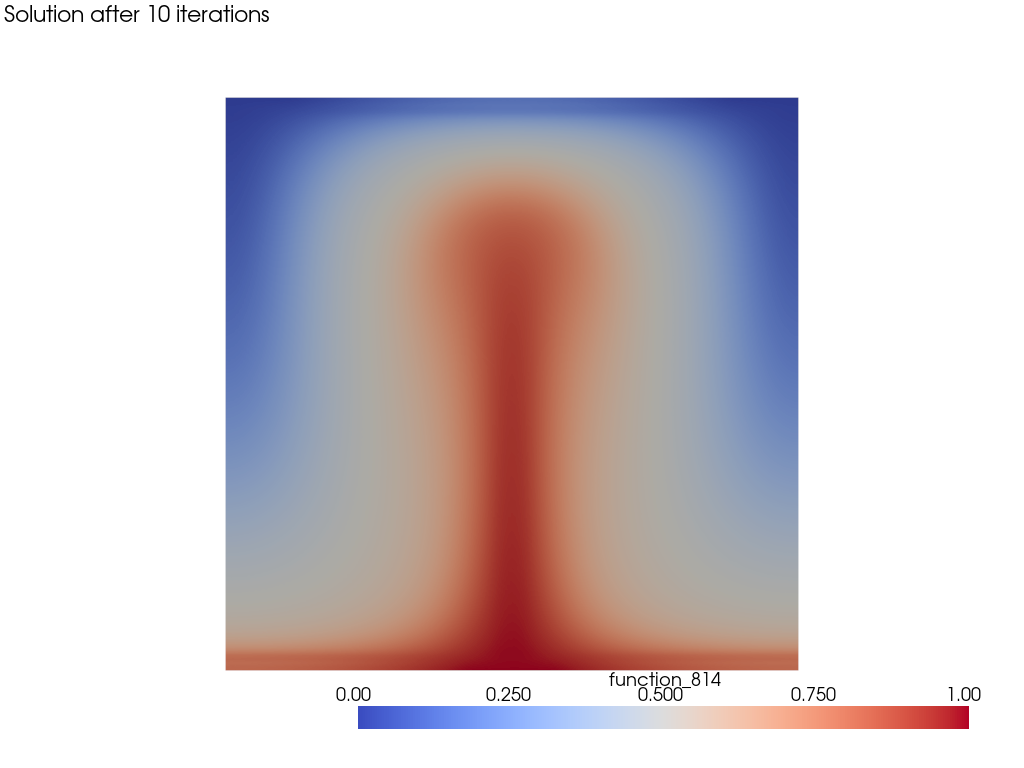

In [23]:
import pyvista as pv
VTKFile("./solution.pvd").write(optimiser.rol_solver.rolvector.dat[0])
dataset = pv.read('./solution.pvd')
# Create a plotter object
plotter = pv.Plotter()
# Add the dataset to the plotter
plotter.add_mesh(dataset, scalars=dataset[0].array_names[0], cmap='coolwarm')
plotter.add_text("Solution after 10 iterations", font_size=10)
# Adjust the camera position
plotter.camera_position = [(0.5, 0.5, 2.5), (0.5, 0.5, 0), (0, 1, 0)]
# Show the plot
plotter.show(jupyter_backend="static")

Text(0.5, 1.0, 'Optimisation convergence')

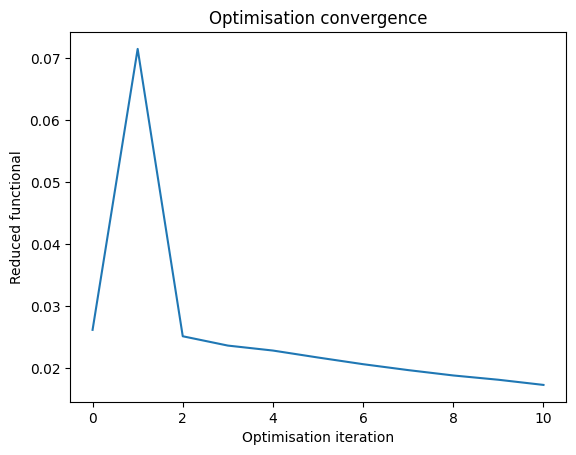

In [24]:
import matplotlib.pyplot as plt
plt.plot(functional_values)
plt.xlabel("Optimisation iteration")
plt.ylabel("Reduced functional")
plt.title("Optimisation convergence")